# <div style="text-align: center">18.335/6.337 Problem Set 2 - QR Factorization</div>
## <div style="text-align: center">Solutions</div>

### <div style="text-align: right">Creaed by Wonseok Shin</div>

## Instruction for electronic submission
- Please archive all files (this Jupyter notebook plus other files if any) into a single ZIP file and upload it to the course website, so that the grader can run the Jupyter notebook in the extracted folder without adding anything.  (This greatly simplifies the grader's job.)
- Some questions may require proofs or explanations, and there are a few options to submit them electronically.
    1. Ideally, write down your proofs or explanations in the corresponding sections of this Jupyter notebook.  You can use $\LaTeX$ commands for mathematical symbols, like $A = \hat{U} \Sigma V^*$, $\sum_{j = 1}^{r} \sigma_j u_j v_j^*$, and $\left[
\begin{array}{cc}
 1 & 2 \\
 3 & 4 \\
\end{array}
\right]$.
    2. If you are not familiar with $\LaTeX$ commands, you can use any word processors with equation editors.  If you choose to use this option, make sure to convert the word processor file into PDF before submission.
    3. If none of the above works for you, you can also submit a scan of your handwritten notes as a last resort, but your handwriting must be clear and readable.

## Problem 1.  CLGS, MGS, and M-CLGS [5 pts]

The functions `clgs()` and `mgs()` appear several times in numerical examples in Trefethen and Bau, but Julia does not provide these functions.  (Neither does MATLAB, because the primary means for the QR factorization is the Householder reflection rather than the Gram-Schmidt procedure.)  In this problem, we will write these functions ourselves so that we can use them later in the course.

We will implement three versions of the Gram–Schmidt procedure: CLGS (Alg. 7.1) and MGS (Alg. 8.1) shown in Trefethen and Bau, and also another version of MGS by modifying a few lines of CLGS, as shown in the class.  The last one will be referred to as the "modified CLGS" (M-CLGS) to distinguish it from MGS.

Throughout this problem, you are welcome to introduce your own *helper functions*.  Whenever you recognize recurring patterns in your code, it is a good programming practice to define a helper function that handles those recurring portions.  Defining helper functions, however, is not a requirement of this problem.

The functions `clgs()` and `mgs()` take $A \in \mathbb{C}^{m\times n}$ as an input and returns the $\hat{Q} \in \mathbb{C}^{m\times n}$ and $\hat{R} \in \mathbb{C}^{n\times n}$ factors of a *reduced* QR factorization of $A$.  Assume $A$ is skinny or square ($m \ge n$).

### Julia programming tips
- In Julia, `Q = A` does *not* create a new storage for `Q`.
    - In MATLAB, `Q = A` creates a new storage for `Q` and copies the contents of `A`.  (MATLAB is actually smarter than this and uses the technique called "lazy copying"; read [this article](http://blogs.mathworks.com/loren/2006/05/10/memory-management-for-functions-and-variables/) if interested.) This means that `Q` and `A` reside in separate memory spaces, so changing the contents of `Q` does not affect `A`. 
    - However, in Julia `Q = A` means that `Q` references `A`.  In other words, `Q` and `A` are two different references to the same memory space, so changing the contents of `Q` changes the contents of `A` as well.  
    - To mimic MATLAB's behavior of `Q = A`, you need to do `Q = copy(A)` in Julia.
- In Julia, you cannot store floating point numbers in an array of integers.
    - For example, `x = [10,11,12]; x[1] = 10.5` throws an [InexactError](http://docs.julialang.org/en/stable/stdlib/base/#Base.InexactError) in Julia.  Here, `x` is created as a vector of integers, so you cannot store a floating point number in `x`.  
    - If you know that `x` could store floating point numbers later, you need to create `x` as a vector of floating point numbers from the beginning, like `x = [10.,11.,12.]`, `x = Float64[10,11,12]`, or `x = float([10,11,12])`.  
    - Question: when `A` is a matrix of integers, do you think it is a good idea to start your code with `Q = copy(A)` in `clgs()` and `mgs()`?

### Assignment 1.1 [2 pts]

Complete `clgs()` below that performs the reduced QR factorization using the *classical* Gram–Schmidt procedure described in Alg. 7.1 of Trefethen and Bau.

Additionally, your `clgs()` must handle the second optional argument `ismodified`.  Perform CLGS for `ismodified = false` (the default value), but M-CLGS for `ismodified = true`.  Handling the `ismodifed` flag inside `clgs()` should not take much programming effort, because the CLGS algorithm turns into the M-CLGS algorithm by changing just a single line in Alg. 7.1.  

The points for this assignment are distributed as follows:
- 1 pt if the function handles full-rank $A$ correctly.
- Additional 1 pt if the function handles rank-deficient $A$ correctly.

*Solution*.

The core of any Gram–Schmidt procedure is orthogonalization of an arbitrary vector $a$ against a given set of orthogonal vectors $\left\{q_1, \ldots, q_k\right\}$, i.e., $a \leftarrow a - (q_1^*a)q_1 - \cdots - (q_k^*a)q_k$.  This orthogonalization step shows up repeatedly in implementing CLGS and MGS, so, we will create a helper function called `ortho_against!` that performs this orthogonalization.  Below, we have two versions of `ortho_against!` with different number of input arguments: one that stores the coefficients $q_j^*a$ in a vector $r$ and the other that simply throws away the coefficients after using them in orthogonalization.  The former is used to construct $R$ of the QR factorization out of $r$, and the latter is used in handling rank-deficient $A$.  

The `!` character at the end the function name is just Julia's function naming convention: append `!` to the names of functions that modify the contents of input arguments (see the documentation [here](http://docs.julialang.org/en/stable/manual/style-guide/#append-to-names-of-functions-that-modify-their-arguments)).  The `!` character itself does not have any magical power in Julia, and your functions will work perfectly fine without `!` appended.  However, following this convention helps the users understand the danger of using the functions and prepare in advance by, e.g., copying the input arguments safely before calling the functions.

In [1]:
"""
    ortho_against!(r, v, a, k, Q)

For a given nonnegative integer `k`, perform v = v - r₁ q₁ - ... - rₖ qₖ, where
- q₁, ..., qₖ are the first `k` columns of `Q`,
- rᵢ = qᵢ⋅a is the coefficient of `a` in the qᵢ direction and stored in r[i].

To use in the modified Gram–Schmidt procedure, call `ortho_against!(r, v, v, k, Q)`, i.e.,
put the vector `v` for `a` as well.

"""
function ortho_against!(r, v, a, k, Q)
    for i = 1:k
        q = @view Q[:,i]
        r[i] = q⋅a  # contents of r updated
        v .-= r[i]*q  # contents of v updated
    end
end

"""
    ortho_against!(v, a, k, Q)

Same as `ortho_against!(r, v, a, k, Q)`, but does not store the coefficients `r`.
"""
function ortho_against!(v, a, k, Q)
    for i = 1:k
        q = @view Q[:,i]
        r = q⋅a
        v .-= r*q  # contents of v updated
    end
end

ortho_against!

Now, here is CLGS implemented by using `ortho_against!`:

In [2]:
function clgs(A, ismodified=false)
    n = size(A, 2)
    T = eltype(A)
    FT = float(T)
    
    Q = similar(A, FT)  # avoid creating complex Q for real A
    copy!(Q, A)  # "!" means contents of Q change
    R = zeros(FT, n, n)

    for j = 1:n
        v = @view Q[:,j]  # use @view because we want to modify Q in-place
        a = ismodified ? v : @view A[:,j]
        r = @view R[:,j]
        ortho_against!(r, v, a, j-1, Q)  # 1st version of ortho_against!
        R[j,j] = norm(v)

        if R[j,j] == 0
            rand!(v)
            a = ismodified ? v : copy(v)
            ortho_against!(v, a, j-1, Q)  # 2nd version of ortho_against!
            normalize!(v)  # "!" means v is normalized in-place
        else
            v ./= R[j,j]
        end
    end

    return Q, R
end

clgs (generic function with 2 methods)

Note that we pass `v` and `a` pointing to the same object when `ismodified = true`.  This is allows `ortho_against!` to update `a` during orthogonalization so that the orthogonalization is carried out in the "modified" fashion.

### Validation of your implementation

Use the following code blocks to validate your implementation of `clgs()`.  The answer you get after each question mark must be `true`.

In [3]:
# For full-rank A
m, n = 10, 7
A = rand(Complex128, m, n);

Q, R = clgs(A)
println("CLGS:")
println("QR ≈ A?  $(Q*R ≈ A)")
println("Q'Q ≈ I?  $(Q'Q ≈ eye(n))")
println()

Q, R = clgs(A, true)
println("MGS:")
println("QR ≈ A?  $(Q*R ≈ A)")
println("Q'Q ≈ I?  $(Q'Q ≈ eye(n))")

CLGS:
QR ≈ A?  true
Q'Q ≈ I?  true

MGS:
QR ≈ A?  true
Q'Q ≈ I?  true


In [4]:
# For rank-deficient A
A = [1 0 0; 1 0 0; 1 0 0; 0 1 0]
m, n = size(A)

Q, R = clgs(A)
println("CLGS:")
println("QR ≈ A?  $(Q*R ≈ A)")
println("Q'Q ≈ I?  $(Q'Q ≈ eye(n))")
println()

Q, R = clgs(A, true)
println("MGS:")
println("QR ≈ A?  $(Q*R ≈ A)")
println("Q'Q ≈ I?  $(Q'Q ≈ eye(n))")

CLGS:
QR ≈ A?  true
Q'Q ≈ I?  true

MGS:
QR ≈ A?  true
Q'Q ≈ I?  true


### Assignment 1.2 [2 pts]

Complete `mgs()` that performs the reduced QR factorization using the *modified* Gram–Schmidt procedure described in Alg. 8.1 of Trefethen and Bau.

The points for this assignment are distributed as follows:
- 1 pt if the function handles full-rank $A$ correctly.
- Additional 1 pt if the function handles rank-deficient $A$ correctly.

*Solution*.

The following is the implementation of MGS.  Here, we cannot use `ortho_against!` for full-rank $A$, because Alg. 8.1 is a row-wise algorithm rather than a column-wise algorthim like Alg. 7.1.  Still, we can use `ortho_against!` to handle rank-deficient cases.

In [5]:
function mgs(A)
    n = size(A, 2)
    T = eltype(A)
    FT = float(T)
    
    Q = similar(A, FT)  # avoid creating complex Q for real A
    copy!(Q, A)
    R = zeros(FT, n, n)

    for i = 1:n
        q = @view Q[:,i]
        R[i,i] = norm(q)

        if R[i,i] == 0
            rand!(q)
            ortho_against!(q, q, i-1, Q)  # 2nd version of ortho_against!
            normalize!(q)
        else
            q ./= R[i,i]
        end

        for j = i+1:n
            v = @view Q[:,j]
            R[i,j] = q⋅v
            v .-= R[i,j]*q
        end
    end
    
    return Q, R
end

mgs (generic function with 1 method)

### Validation of your implementation

Use the following code blocks to validate your implementation of `mgs()`.  The answer you get after each question mark must be `true`.  

Note that `mgs(A)` should return *exactly* the same numbers as `clgs(A, true)` for full-rank `A`, because MGS and M-CLGS are just different ways of implementing the same modified Gram–Schmidt procedure.  The only difference is which of the row and column indices varies faster: in MGS (Alg. 8.1) the inner loop changes the column index $j$ and the outer loop changes the row index $i$, whereas M-CLGS (one-line modificationt of Alg. 7.1) does the opposite.

In [6]:
# For full-rank A
m, n = 10, 7
A = rand(Complex128, m, n);

Qm, Rm = mgs(A)
println("MGS:")
println("QR ≈ A?  $(Qm*Rm ≈ A)")
println("Q'Q ≈ I?  $(Qm'Qm ≈ eye(n))")
println()

Qcl, Rcl = clgs(A, true)
println("Comparison with clgs(A, true):")
println("Same Q?  $(Qm == Qcl)")
println("Same R?  $(Rm == Rcl)")

MGS:
QR ≈ A?  true
Q'Q ≈ I?  true

Comparison with clgs(A, true):
Same Q?  true
Same R?  true


In [7]:
# For rank-deficient A
A = [1 0 0; 1 0 0; 1 0 0; 0 1 0]
m, n = size(A)

Qm, Rm = mgs(A)
println("MGS:")
println("QR ≈ A?  $(Qm*Rm ≈ A)")
println("Q'Q ≈ I?  $(Qm'Qm ≈ eye(n))")
println()

Qcl, Rcl = clgs(A, true)
println("Comparison with modified CLGS:")
println("Same q₁ and q₂?  $(Qm[:,1:2] == Qcl[:,1:2])")
println("Different q₃?  $(Qm[:,3] ≠ Qcl[:,3])")  # q₃ is not uniquely determined, because r₃₃ = 0
println("Same R?  $(Rm == Rcl)")

MGS:
QR ≈ A?  true
Q'Q ≈ I?  true

Comparison with modified CLGS:
Same q₁ and q₂?  true
Different q₃?  true
Same R?  true


### Assignment 1.3 [1 pt]

It is known that the columns of $\hat{Q}$ constructed by MGS are closer to being orthogonal than those constructed by CLGS.  In this assignment we numerically verify if this is really the case.

The quality of orthogonality of the columns of $Q$ can be measured by the error in $\hat{Q}^* \hat{Q}$: if it is closer to $I$, the columns of $\hat{Q}$ are closer to being orthogonal.

Complete `compare_gs()` below that measures the errors in $\hat{Q}^* \hat{Q}$ for $N$ randomly generated test matrices of size $m$-by-$n$.  Use the matrix 1-norm to measure the errors.

In [8]:
function compare_gs(N, m, n)
    I = eye(n)
    errI_cl = Vector{Float64}(N)
    errI_m = Vector{Float64}(N)
    
    for i = 1:N
        A = rand(m,n)
        Qcl, ~ = clgs(A)
        Qm, ~ = mgs(A)
        
        errI_cl[i] = norm(Qcl'Qcl - I, 1)
        errI_m[i] = norm(Qm'Qm - I, 1)
    end
    
    return errI_cl, errI_m  # two length-N vectors containing errors in Q'Q for Q by clgs(A)
end

compare_gs (generic function with 1 method)

### Validation of your implementation

Use the following code block to plot the measured errors.  You will see that the errors for MGS stay always lower than the errors for CLGS for all matrices.

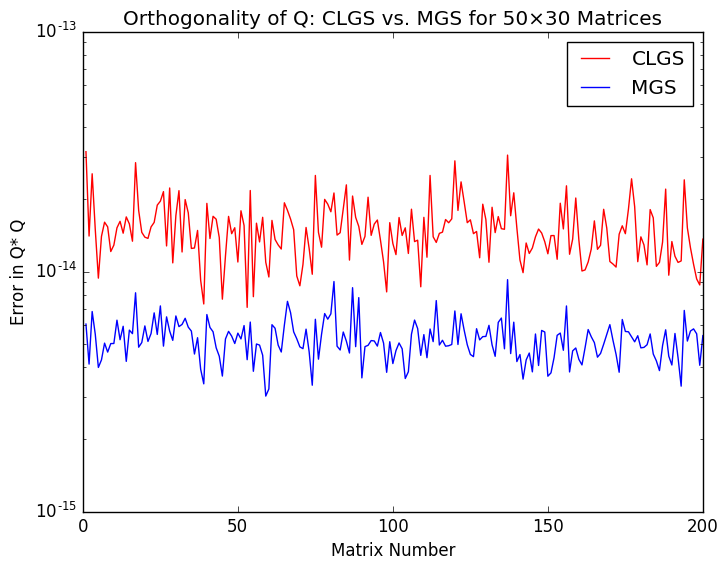

PyObject <matplotlib.legend.Legend object at 0x32105edd8>

In [9]:
N = 200
m, n = 50, 30
errI_cl, errI_m = compare_gs(N, m, n)

using PyPlot  # if not installed yet, execute Pkg.add("PyPlot") first

semilogy(1:N, errI_cl, "r-", 1:N, errI_m, "b-")
title("Orthogonality of Q: CLGS vs. MGS for $m×$n Matrices")
xlabel("Matrix Number")
ylabel("Error in Q* Q")
legend(["CLGS", "MGS"])

## Problem 2.  Intersection of subspaces [3 pts]

(Partly taken from Exercise 7.4 of Trefethen and Bau)

(a) [1 pt] `mgs()` written in Prob. 1 performs the *reduced* QR factorization for a skinny matrix $A$.  Explain how to perform the *full* QR factorization using mgs() for a skinny matrix $A$.

*Solution*.

Attach random $m-n$ columns to $A$ to make it square, and pass the expanded matrix to `mgs()`.  From the resulting $Q$ and $R$, keep the entire $Q$ but discard the last $m-n$ columns of $R$.

(b) [2 pts] Consider a subspace of $\mathbb{R}^3$ spanned by $a_1 = [0.9, 0.3, 0.2]^\top$ and $a_2 = [0.5, 0.9, 0.6]^\top$, and another subspace spanned by $b_1 = [0.1, 0.6, 0.1]^\top$ and $b_2 = [0.7, 0.4, 0.6]^\top$.  The two subspaces are planes in $\mathbb{R}^3$ containing the origin, and the intersection between the two is a line passing through the origin.  Complete the code block below that finds the direction of this intersection line by using `mgs()` three times.

*Solution*.

A plane is defined as a set of all lines passing through one point (the origin in the present context) that are orthogonal to a given vector, which is called the normal vector of the plane.  You are given two in-plane directions for each plane.  If you construct a $3\times 2$ matrix $A$ using these in-plane directions as columns and perform the full QR factorization $A = Q R$, the first two columns of $Q$ are still in-plane directions, but the third column of $Q$ is the direction orthogonal to the first two columns of $Q$, so it is the direction normal to the plane.  Therefore, you can find the normal vector of a plane by performing the full QR factorization.

Once you find the normal vectors of the two planes this way, you can use them to find the intersection between the two planes.  From the previous definition of a plane, we realize that the intersection between two planes is the line that is *simultaneously* orthogonal to the normal vectors of the two planes.  We have already explained how to find the direction orthogonal to two vectors (which happen to be the normal vectors of the two planes now) by performing the full QR factorization.

The following is the implementation of the above procedure in Julia:

In [10]:
a₁ = [0.9, 0.3, 0.2]
a₂ = [0.5, 0.9, 0.6]

b₁ = [0.1, 0.6, 0.1]
b₂ = [0.7, 0.4, 0.6]

A = [a₁ a₂]
B = [b₁ b₂]

Qa, ~ = mgs([A rand(3)])
Qb, ~ = mgs([B rand(3)])

a₃ = @view Qa[:,3]  # direction normal to first plane
b₃ = @view Qb[:,3]  # direction normal to second plane

Qv, Rv = mgs([a₃ b₃ rand(3)])

v = @view Qv[:,3]

println("Intersection is along v = $v.")

Intersection is along v = [0.534673,0.703132,0.468754].


## Problem 3.  Rank and QR factorization [2 pts]

(Partly taken from Exercise 7.5 of Trefethen and Bau)

Let $A$ be an $m \times n$ matrix ($m \ge n$), and let $A = \hat{Q} \hat{R}$ be a reduced QR factorization.

(a) [1 pt] Show that $\mathrm{rank}(A)=n$ if and only if all the diagonal entries of $\hat{R}$ are nonzero.

*Proof*.

("if" part) Because $\hat{R}$ is square upper triangular, $\det(\hat{R})$ is the product of the diagonal entries of $\hat{R}$, which is nonzero because all the diagonal entries of $\hat{R}$ are nonzero.  This means $\hat{R}$ is invertible.  An invertible matrix preserves the rank of the matrix it is multiplied with.  Therefore, $\mathrm{rank}(A) = \mathrm{rank}(\hat{Q}\hat{R}) = \mathrm{rank}(\hat{Q})$.  Because all the columns of $\hat{Q}$ are orthogonal to each other, $\mathrm{rank}(\hat{Q}) = n$, which proves $\mathrm{rank}(A) = n$.

("only if" part)  This is obvious from the Gram–Schmidt procedure.

(b) [1 pt] Suppose $\hat{R}$ has $k$ nonzero diagonal entries for some $k$ with $0 \le k \le n-1$.  Show that $\mathrm{rank}(A) \ge k$ but the equality does not always hold (i.e., $\mathrm{rank}(A)$ could be greater than $k$ for some $A$).

*Proof*.

This time, consider the full QR factorization $A = Q R$ instead of the reduced QR factorization $A = \hat{Q} \hat{R}$ for a moment.  Because $Q$ is invertible, it preserves the rank of the matrix it is multiplied with.  Therefore, $\mathrm{rank}(A) = \mathrm{rank}(Q R) = \mathrm{rank}(R)$.  Here, notice $R = \left[
\begin{array}{c}
 \hat{R} \\
 0 \\
\end{array}
\right]$ has the same number of nonzero diagonal entries as $\hat{R}$.  Therefore, $R$ has $k$ nonzero diagonal entries, and its *rows* corresponding to those nonzero diagonal entries are linearly independent.  Theferore, $R$ has at least $k$ linearly independent rows, which proves $\mathrm{rank}(R) \ge k$, and hence $\mathrm{rank}(A) \ge k$.


To show that $\mathrm{rank}(A)$ is not always equal to $k$ but is greater than $k$ for some $A$, it suffices to construct such $A$.  Consider
$$
A=\left[
\begin{array}{ccc}
 1 & 1 & 0 \\
 0 & 0 & 1 \\
 0 & 0 & 0 \\
\end{array}
\right].
$$
This is already upper-triangular, so its reduced QR factorization is $\hat{Q} = I$ and $\hat{R} = A$.  Notice $\hat{R}$ has only 1 nonzero diagonal entry while $\mathrm{rank}(A) = 2 > 1$.

## Bonus problem.  QR factorization with column pivoting [3 pts]

(Note: the score of this bonus problem will be added to your total problem set score at the end of the semester.  However, your total problem set score cannot exceed the perfect problem set score without bonus problems.  In other words, 
$$
\text{your total p-set score} = \min\left\{\sum_n\text{your $n$th p-set score $with$ bonus problems}, \sum_n\text{perfect $n$th p-set score $without$ bonus problems}\right\}.
$$
So solve bonus problems to compensate for the deducted points in your problem sets.)

Consider a skinny or square matrix $A \in \mathbb{C}^{m\times n}$ ($m\ge n$).  For a full-rank $A$, the reduced QR factorization $A = \hat{Q} \hat{R}$ is a nice way to construct an orthonormal basis of $\mathrm{range}(A)$: the columns of $\hat{Q}$ are the orthonormal basis vectors.

However, for a rank-deficient $A$, the reduced QR factorization does not provide useful information about the basis of $\mathrm{range}(A)$.  Problem 3b states that $\mathrm{rank}(A)$ is the number of nonzero diagonal entries of $\hat{R}$ or *more*, so we know simply picking the columns of $\hat{Q}$ corresponding to the nonzero diagonal entries of $\hat{R}$ does not provide enough number of vectors to form a basis of $\mathrm{range}(A)$.  Moreover, when some diagonal entry $r_{j_0j_0}$ of $\hat{R}$ turns out to be zero during the Gram–Schmidt procedure, we throw in a random vector to construct $q_{j_0}$.  This $q_{j_0}$ is not necessarily within $\mathrm{range}(A)$, but it is still subtracted from the columns of $A$ when constructing the columns of $\hat{Q}$ after $q_{j_0}$.  Therefore, all the columns of $\hat{Q}$ constructed after $q_{j_0}$ are also outside $\mathrm{range}(A)$.

One way to construct an orthonormal basis of $\mathrm{range}(A)$ by the Gram–Schmidt procedure is to incorporate column pivoting.  The resulting reduced QR factorization is of the form
$$
A P = \hat{Q}\hat{R},
$$
where $P$ is a column permutation matrix.  In Julia notation, this can be written 
$$
A_{:,p} = \hat{Q} \hat{R},
$$
where $p$ is a vector indicating the permuted column indices of $A$.

The column permutation is carried out to keep the diagonal entries of $\hat{R}$ nonincreasing in magnitude, i.e., 
$$
\left|r_{11}\right| \ge \cdots \ge \left|r_{kk}\right| > 0 = \left|r_{k+1,k+1}\right| = \cdots = \left|r_{nn}\right|.  
$$

### Assignment B.1 [2 pts]

Complete `qrp()` below that performs the reduced QR factorization with column pivoting.  

Hint 1.  The procedure is simiar to MGS than CLGS.  In other words, as soon as you obtain $q_j$, subtract the $q_j$ components from all the remaining columns of $A$.

Hint 2.  Do not attempt to figure out the entire permutation first and then perform the reduced QR factorization.  You can construct the permutation gradually on the fly.  It is pretty obvious which column of $A$ needs to be put into the first column.  Perform the first permutation for such arrangement of columns, and then carry out MGS with the first column.  Think about which column of $A$ to put into the second column.  Repeat the procedure.

*Solution*.

Suppose the step $i = k$ of MGS with column pivoting is just finished and the column permutation accumulated up to this point is $p^{(k)}$.  Then, the matrix looks like
$$
A_{:,p^{(k)}} = \left[
\begin{array}{cc}
\underbrace{q_1 \cdots  q_k}_{\hat{Q}_{:,1:k}} & \underbrace{v_{k+1}^{(k+1)} \cdots  v_n^{(k+1)}}_{V^{(k+1)}}
\end{array}
\right] 
\left[
\begin{array}{cc}
\hat{R}_{1:k,1:k} & S^{(k+1)}\\
 0 & I
\end{array}
\right]
$$

Now, at the beginning of the step $i = k+1$ of MGS with column pivoting, we choose one of the columns $v_{k+1}^{(k+1)}, \ldots,v_n^{(k+1)}$ and normalize it to produce the next orthogonal direction $q_{k+1}$.  Because the norm of the chosen column becomes the next diagonal entry $r_{k+1,k+1}$ of $\hat{R}$, we choose the column with the largest norm among $v_{k+1}^{(k+1)}, \ldots,v_n^{(k+1)}$ and normalize it.  Therefore, the column permutation to perform at the beginning of the step $i = k+1$ is the one that brings the chosen column to the $(k+1)$th column of the column-permuted matrix $A$.

Note that this column permutation operator, which is denoted by $P_{k+1}$, is multiplied to the right of $A_{:,p^{(k)}}$ on the left-hand side of the above equation.  What this permutation operator does on the right-hand side of the equation is interesting.  It permutes the columns of $\left[
\begin{array}{c}
S^{(k+1)}\\
I
\end{array}
\right]$, but then the lower block $I$ becomes no longer an identity matrix.  However, the identy matrix is recovered once we permute the columns $v_{k+1}^{(k+1)}, \ldots,v_n^{(k+1)}$ with the same column permutation operator, because
$$
A_{:,p^{(k)}} P_{k+1} = \left(\left[
\begin{array}{cc}
q_1 \cdots  q_k & v_{k+1}^{(k+1)} \cdots  v_n^{(k+1)}
\end{array}
\right] P_{k+1} \right)
\left(P_{k+1}
\left[
\begin{array}{cc}
\hat{R}_{1:k,1:k} & S^{(k+1)}\\
 0 & I
\end{array}
\right] P_{k+1} \right).
$$
Therefore, permuting the last $n-k$ columns of $A_{:,p^{(k)}}$ with $P_{k+1}$ is equivalent to permuting the columns $v_{k+1}^{(k+1)}, \ldots,v_n^{(k+1)}$ while maintaining the identity matrix at the lower-right block of the second parenthesized matrix above.  Then, when the $(k+1)$th column of the first parenthesized matrix is normalized, the norm of the column before normalization becomes the new diagonal entry $r_{k+1,k+1}$ in the second parenthesized matrix.  We can repeat this procedure until factorization is done.

`qrp` below implements the above explained procedure.

In [25]:
function qrp(A)
    n = size(A, 2)
    T = eltype(A)
    FT = float(T)
    
    Q = similar(A, FT)
    copy!(Q, A)
    R = zeros(FT, n, n)
    
    r = Vector{Float64}(n)  # storage for norms of columns
    r0 = Vector{Float64}(n)  # storage for norms of initial columns; used to determine numerically rank-deficient case
    for j = 1:n
        a = @view A[:,j]
        r0[j] = norm(a)
    end

    p = collect(1:n)  # permuted column indices
    
    for i = 1:n
        for j = 1:n
            a = @view Q[:,j]
            r[j] = norm(a)
        end
        
        # Among the column i through n, find the one to be brought to the ith column.
        ~, ip = findmax(@view r[i:n])
        ip += i-1
        
        # If the found column is not already the ith column, do the permutation to bring it to the ith column.
        if ip ≠ i
            p[i], p[ip] = p[ip], p[i]
            r[i], r[ip] = r[ip], r[i]
            r0[i], r0[ip] = r0[ip], r0[i]
            R[:,i], R[:,ip] = R[:,ip], R[:,i]
            Q[:,i], Q[:,ip] = Q[:,ip], Q[:,i]
        end

        R[i,i] = r[i]

        # Handle rank-deficient cases.
        q = @view Q[:,i]
        if R[i,i] < 1e-10r0[i]  # numerically rank-deficient
            rand!(q)
            ortho_against!(q, q, i-1, Q)
            normalize!(q)
        else
            q ./= R[i,i]
        end

        # Perform the inner loop of MGS.
        for j = i+1:n
            v = @view Q[:,j]
            R[i,j] = q⋅v
            v .-= R[i,j]*q
        end
    end
    
    return Q, R, p  # A[:,p] = Q*R
end

qrp (generic function with 1 method)

### Validation of your implementation

Use the following code block to validate your implementation.  Check if the last three rows of $\hat{R}$ are nearly zero.  They may not be completely zero due to round-off errors, but as long as they are significantly smaller than the entries of the rows above, your implementation is fine.

In [26]:
# Construct a rank-deficient A.
m, n = 10, 6
A = zeros(m, n)
rand!(@view A[:, [1,2,6]])
for j = 3:5
    A[:,j] .+= rand() .* (@view A[:,1])
    A[:,j] .+= rand() .* (@view A[:,2])
end

# Perform the reduced QR factorization with column pivoting.
Q, R, p = qrp(A)

println("MGS with column pivoting:")
println("QR ≈ A[:,p]?  $(Q*R ≈ A[:,p])")
println("Decreasing rᵢᵢ?  $(issorted(diag(R), rev=true))")
println("Q'Q ≈ I?  $(Q'Q ≈ eye(n))")
println("R[4:6,:] ≈ 0? $(isapprox(R[4:6,:], zeros(3,6), atol = 10eps()))")

MGS with column pivoting:
QR ≈ A[:,p]?  true
Decreasing rᵢᵢ?  true
Q'Q ≈ I?  true
R[4:6,:] ≈ 0? true


### Assignment B.2 [1 pt]

(a) Show that the permutation used in the reduced QR factorization ensures that the rows of $\hat{R}$ below the $k$th row are completely zero in exact arithmetic (i.e., ignoring round-off errors).  In other words, $A_{:,p}$ is of the form
$$
A_{:,p} = \hat{Q} \left[
\begin{array}{c}
 \hat{R}_{1:k,:} \\
 0 \\
\end{array}
\right].
$$

Also, find $\mathrm{rank}(A)$ and an orthonormal basis of $\mathrm{range}(A)$ from this result.

*Proof and answers*.

The permutation ensures 
$$
\left|r_{ii}\right| \ge \left\|\hat{R}_{i:j,j}\right\| \;\text{for}\; j > i,
$$  
because otherwise we would have $\left|r_{ii}\right| < \left\|\hat{R}_{i:j,j}\right\|$ for some $j > i$ and swapping the $j$th and $i$th columns would produce a greater $\left|r_{ii}\right|$.  The above inequality can be written with slightly relaxed condition on $j$ as
$$
\left|r_{ii}\right| \ge \left\|\hat{R}_{i:j,j}\right\| \;\text{for}\; j \ge i,
$$  
because the inequality holds obviously for $j = i$.

When combined with $\left|r_{k+1,k+1}\right| = 0$, the inequality implies $\left\|\hat{R}_{k+1:j,j}\right\| = 0$ for $j \ge k+1$.  Because $\hat{R}_{j+1:m,j} = 0$ due to the upper-triangular shape of $\hat{R}$, we can further write $\left\|\hat{R}_{k+1:m,j}\right\| = 0$ for $j \ge k+1$, which implies $r_{ij} = 0$ for all $i, j \ge k+1$.  Therefore, the rows of $\hat{R}$ below the $k$th row are completely zero.

From this result, we have $A_{:,p} = \hat{Q}_{:,1:k} \hat{R}_{1:k,:}$.  We can use this to prove that the first $k$ columns of $\hat{Q}$ form an orthonormal basis of $\mathrm{range}(A)$.  First, notice $\mathrm{range}(\hat{R}_{1:k,:}) = \mathbb{C}^k$ because $\hat{R}_{1:k,:}$ is fat and full-rank.  Therefore, $\mathrm{range}(A) = \mathrm{range}(A_{:,p}) = \mathrm{range}(\hat{Q}_{:,1:k} \hat{R}_{1:k,:}) = \mathrm{range}(\hat{Q}_{:,1:k})$.  In addition to this, because the columns of $\hat{Q}_{:,1:k}$ are orthonormal, we conclude they, or the first $k$ columns of $\hat{Q}$, form an orthonormal basis $\mathrm{range}(A)$.  Accordingly, $\mathrm{rank}(A) = k$, the number of columns of $\hat{Q}_{:,1:k}$.

This proves the usefulness of the QR factorization with column pivoting: you can easily find out the rank of $A$ and an orthonormal basis of the range of $A$ using the QR factorization with column pivoting.